In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy.fftpack import fft, fftfreq, fftshift

from glob import glob
from subprocess import call
from os.path import join, splitext

import dicom as dcm
from dcmextras.siemenscsa import csa, phoenix
from dcmfetch import fetch_series

In [2]:
patid = 'PQA20180117BCHL4'
stuid = '1'
dobj = fetch_series(patid, stuid, [62])[0]

There is not much information in the standard DICOM tags but we can get a lot from the image csa and even more from the phoenix protocol

In [3]:
def dump_params(dobj):
    info = csa(dobj, 'image')
    data_point_columns = info['DataPointColumns']
    phase_rows = info['Rows']
    phase_columns = info['Columns']
    number_of_frames = info['NumberOfFrames']
    echo_time = info['EchoTime']
    imaging_frequency = info['ImagingFrequency']
    averages = info['NumberOfAverages']
    real_dwell_time = info['RealDwellTime']
    raw_data_columns = info['SpectroscopyAcquisitionDataColumns']
    raw_phase_rows = info['SpectroscopyAcquisitionPhaseRows']
    raw_phase_columns = info['SpectroscopyAcquisitionPhaseColumns']
    raw_outofplane_phase_steps = info['SpectroscopyAcquisitionOut-of-planePhaseSteps']
    data_representation = info['DataRepresentation']
    pixel_bandwidth = info['PixelBandwidth']
    interpolated = not (
        data_point_columns == raw_data_columns and
        phase_rows == raw_phase_rows and
        phase_columns == raw_phase_columns and
        number_of_frames == raw_outofplane_phase_steps
    )

    print('Imaging Frequency:', imaging_frequency, 'MHz')
    print('Echo Time:', echo_time, 'ms')
    print('Averages:', averages)
    print('Real Dwell Time:', real_dwell_time, '(ns?)')
    print('Data Point Columns:', data_point_columns)
    print('Phase Rows:', phase_rows)
    print('Phase Columns:', phase_columns)
    print('Number of Frames:', number_of_frames)
    print('Raw Data Columns:', raw_data_columns)
    print('Raw Phase Rows:', raw_phase_rows)
    print('Raw Phase Columns:', raw_phase_columns)
    print('Raw Out of Plane Phase Steps:', raw_outofplane_phase_steps)
    print('Interpolated: %s' % ('yes' if interpolated else 'no'))
    print('Data Representation:', data_representation)
    print('Pixel Bandwidth:', pixel_bandwidth, 'Hz')
    
    pnx = phoenix(dobj)
    dwell_time = float(pnx["sRXSPEC.alDwellTime[0]"])
    sampling_frequency = 1e9 / (2 * float(pnx["sRXSPEC.alDwellTime[0]"]))
    transmitter_frequency = float(pnx["sTXSPEC.asNucleusInfo[0].lFrequency"])
    echo_time = float(pnx["alTE[0]"]) / 1e6            
    #ncols = int(phoenix(dobj)["sSpecPara.lFinalMatrixSizePhase"])
    #nrows = int(phoenix(dobj)["sSpecPara.lFinalMatrixSizeRead"])
    nslices = int(pnx["sSpecPara.lFinalMatrixSizeSlice"])
    vector_size = pnx["sSpecPara.lVectorSize"]
    preparing_scans = pnx["sSpecPara.lPreparingScans"]
    phase_cycling_type = pnx["sSpecPara.lPhaseCyclingType"]
    excitation_bandwidth = pnx["sSpecPara.lRFExcitationBandwidth"]
    remove_oversampling = pnx["sSpecPara.ucRemoveOversampling"]
    delta_frequency = pnx["sSpecPara.dDeltaFrequency"]
    spectral_suppression = pnx["sSpecPara.lSpectralSuppression"]
    water_suppression_bandwidth = pnx["sSpecPara.dSpecWaterSupprBandwidth"]

    print('Dwell Time:', dwell_time, 'ns')
    print('Sampling Frequency:', sampling_frequency, 'Hz')
    print('Transmitter Frequency:', transmitter_frequency, 'Hz')
    print('Echo Time:', echo_time, 's')
    #print('Number of Columns:', ncols)   
    #print('Number of Rows:', nrows)
    print('Number of Slices:', nslices)

    print('Vector Size:', vector_size)
    print('Preparing Scans:', preparing_scans)
    print('Phase Cycling Type:', phase_cycling_type)
    print('Excitation Bandwidth:', excitation_bandwidth)
    print('Remove Oversampling:', remove_oversampling)
    print('Delta Frequency:', delta_frequency)
    print('Spectral Suppression:', spectral_suppression)
    print('Water Suppression Bandwidth:', water_suppression_bandwidth)

In [4]:
dump_params(dobj)

Imaging Frequency: 123.257996 MHz
Echo Time: 30.0 ms
Averages: 16.0
Real Dwell Time: 833400 (ns?)
Data Point Columns: 2048
Phase Rows: 1
Phase Columns: 1
Number of Frames: 1
Raw Data Columns: 2048
Raw Phase Rows: 1
Raw Phase Columns: 1
Raw Out of Plane Phase Steps: 1
Interpolated: no
Data Representation: COMPLEX
Pixel Bandwidth: 600.0 Hz
Dwell Time: 416700.0 ns
Sampling Frequency: 1199.9040076793856 Hz
Transmitter Frequency: 123257996.0 Hz
Echo Time: 0.03 s
Number of Slices: 1
Vector Size: 2048
Preparing Scans: 4
Phase Cycling Type: 2
Excitation Bandwidth: 50
Remove Oversampling: 0x1
Delta Frequency: -2.9
Spectral Suppression: 1
Water Suppression Bandwidth: 1.55


The is probably enough for SVS though we can get geometry information as well. Need top resolve true dwell time. It will depend if the data has already had the oversampling removed 0.2ms is probably the oversampled value and 0.4ms when it is removed.

We get the complex data from the private tag `(0x7fe1, 0x1010)`. Should be 32 bit floats, alternating real/imaginary (different from rda, which uses doubles instead of floats?)

In [10]:
def get_complex_signal(dobj):
    tagval = dobj[0x7fe1, 0x1010].value
    x = np.array(struct.unpack('%df' % (len(tagval)//4), tagval))
    re, im = x[::2], x[1::2]
    return re + 1j*im

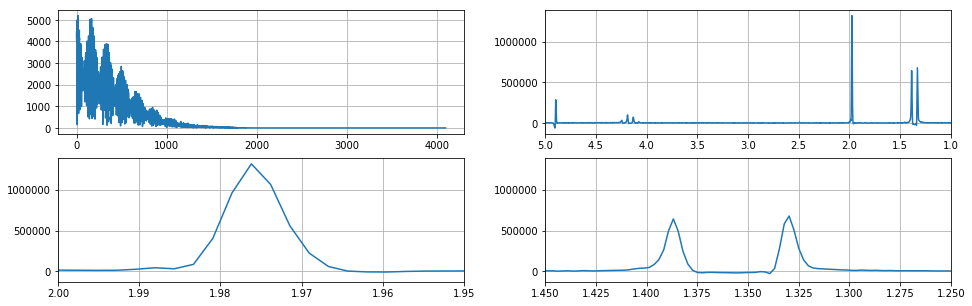

In [99]:
from scipy.signal import tukey

z = get_complex_signal(dobj)

# apodization
alpha = 0.5
z *= tukey(2*len(z), alpha=alpha)[len(z):]

# zero fill
z = np.r_[z, np.zeros_like(z)]

# fft
spectrum = fftshift(fft(z))

# in addition here we could apply a phase correction at this point

dwell_time = float(phoenix(dobj)["sRXSPEC.alDwellTime[0]"])
larmor_freq = csa(dobj, 'image')['ImagingFrequency']

# Water reference frequency is usually 4.65-4.7 but at room temperature a value of 4.85 is recommended
# However even this doesn't seem to be quite right. Looks like Siemens use 4.89 so we'll use that.
water_ppm = -4.89

# Siemens dwell time is in nanoseconds and is the original time before the x2 oversampling is discarded
effective_dwell_time_s = 2 * dwell_time * 1e-9

# Frequencies relative to water in ppm
frequencies = fftshift(fftfreq(len(z), d=effective_dwell_time_s)) / larmor_freq + water_ppm

# We now need to do the peak fitting - which is a bit more difficult

fig, axs = plt.subplots(2, 2, figsize=(16, 5))
axs = axs.flat
axs[0].plot(abs(z))
#axs[0].set_xlim([1900, 2048])
axs[0].grid(True)
axs[1].plot(-frequencies, spectrum.real)
axs[1].set_xlim([5, 1])
axs[1].grid(True)
axs[2].plot(-frequencies, spectrum.real)
axs[2].set_xlim([2.0, 1.95])
axs[2].grid(True)
axs[3].plot(-frequencies, spectrum.real)
axs[3].set_xlim([1.45, 1.25])
axs[3].grid(True);